## To relate humidity to the Urban Heat Island (UHI). Analysis of the humidity variable.

In [19]:
import os
import pandas as pd
import numpy as np

# Absolute path
RAW_AEMET_DIR = os.path.abspath("../data/raw/aemet")

# Loading data CSVs
dfs = []
files = [f for f in os.listdir(RAW_AEMET_DIR) if f.endswith(".csv")]

for fname in files:
    df = pd.read_csv(os.path.join(RAW_AEMET_DIR, fname))
    df["archivo"] = fname
    dfs.append(df)

meteo = pd.concat(dfs, ignore_index=True)

# cleaning and preprocessing
meteo["fecha"] = pd.to_datetime(meteo["fecha"], errors="coerce")

num_cols = ["tmed","tmax","tmin","prec","sol","hrMedia","presMax","presMin","altitud"]
for col in num_cols:
    if col in meteo.columns:
        meteo[col] = pd.to_numeric(meteo[col], errors="coerce")

meteo = meteo.dropna(subset=["fecha"])

meteo["year"] = meteo["fecha"].dt.year


In [20]:
# Valid years with at least 250 days of data
valid_years = (
    meteo.groupby(["nombre", "year"])["hrMedia"]
    .count()
    .reset_index()
    .rename(columns={"hrMedia": "days"})
)

valid_years = valid_years[valid_years["days"] >= 250]

meteo_clean = meteo.merge(valid_years[["nombre", "year"]], on=["nombre", "year"])


In [21]:
# Annual average humidity
annual_hr = (
    meteo_clean.groupby(["nombre", "year"], as_index=False)["hrMedia"]
    .mean()
)
annual_hr.head()


,nombre,year,hrMedia
0,BARCELONA AEROPUERTO,1980,73.188525
1,BARCELONA AEROPUERTO,1981,71.719780
2,BARCELONA AEROPUERTO,1982,73.715068
3,BARCELONA AEROPUERTO,1983,71.820937
4,BARCELONA AEROPUERTO,1984,72.825137


In [22]:
import os
# Directory to save reports and plots to humidity
SAVE_DIR = os.path.join(os.path.dirname(os.getcwd()), "reports", "humidity")
os.makedirs(SAVE_DIR, exist_ok=True)



In [23]:
import matplotlib.pyplot as plt

# Plotting function for humidity trend
def plot_hr_trend(df, station_name):
    data = df[df["nombre"] == station_name].dropna(subset=["hrMedia"])
    years = data["year"].values
    hr_vals = data["hrMedia"].values
    
    slope, intercept = np.polyfit(years, hr_vals, 1)
    trend = slope * years + intercept
    
    plt.figure(figsize=(8,4))
    plt.plot(years, hr_vals, label="HR anual (%)")
    plt.plot(years, trend, '--', label=f"Tendència: {slope*10:.2f}% per dècada")
    plt.title(f"Humitat relativa mitjana anual — {station_name}")
    plt.xlabel("Any")
    plt.ylabel("HR (%)")
    plt.grid(True, alpha=0.4)
    plt.legend()
    filename = f"humitat_relativa_mitjana_anual_{station_name.replace(' ', '_')}.png"
    plt.savefig(os.path.join(SAVE_DIR, filename), dpi=300, bbox_inches="tight")

    plt.show()
    
    print(f"📈 Tendència {station_name}: {slope:.3f}% per any  ({slope*10:.2f}% per dècada)")


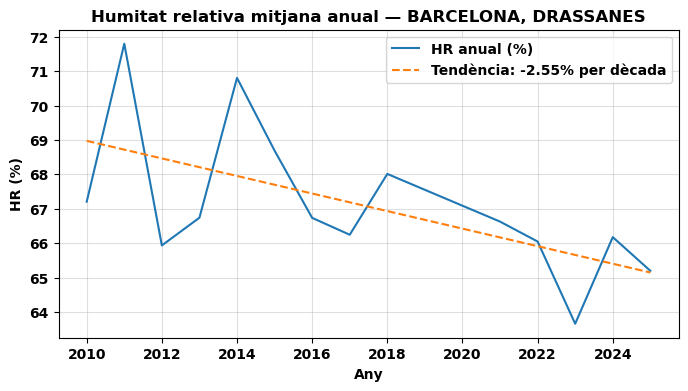

📈 Tendència BARCELONA, DRASSANES: -0.255% per any  (-2.55% per dècada)


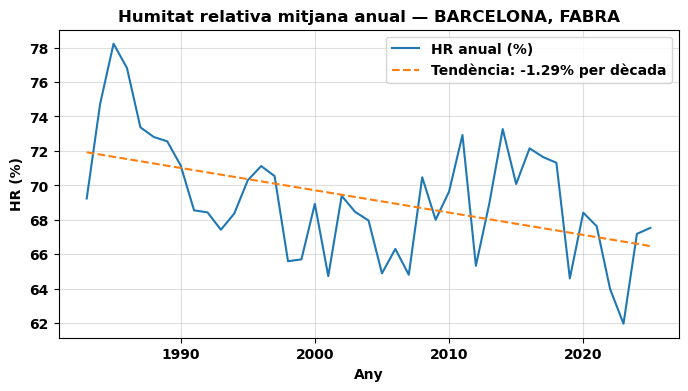

📈 Tendència BARCELONA, FABRA: -0.129% per any  (-1.29% per dècada)


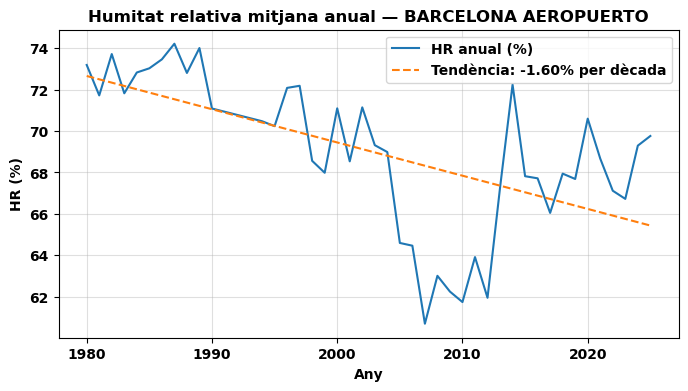

📈 Tendència BARCELONA AEROPUERTO: -0.160% per any  (-1.60% per dècada)


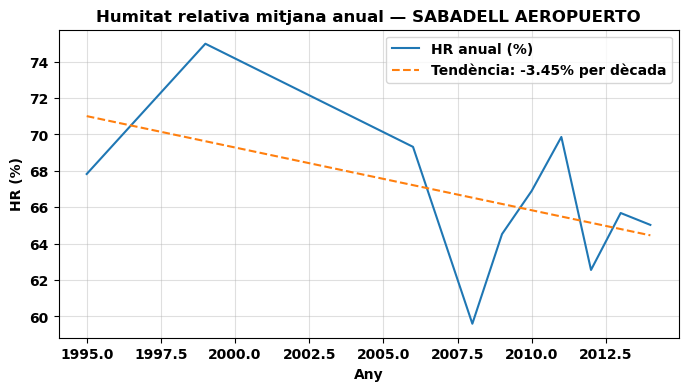

📈 Tendència SABADELL AEROPUERTO: -0.345% per any  (-3.45% per dècada)


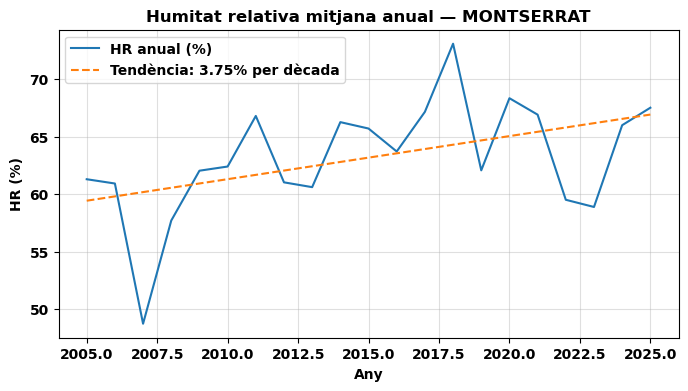

📈 Tendència MONTSERRAT: 0.375% per any  (3.75% per dècada)


In [24]:

# Our stations of interest (Barcelona and surroundings)
stations = [
    "BARCELONA, DRASSANES",
    "BARCELONA, FABRA",
    "BARCELONA AEROPUERTO",
    "SABADELL AEROPUERTO",
    "MONTSERRAT"
]

for st in stations:
    plot_hr_trend(annual_hr, st)


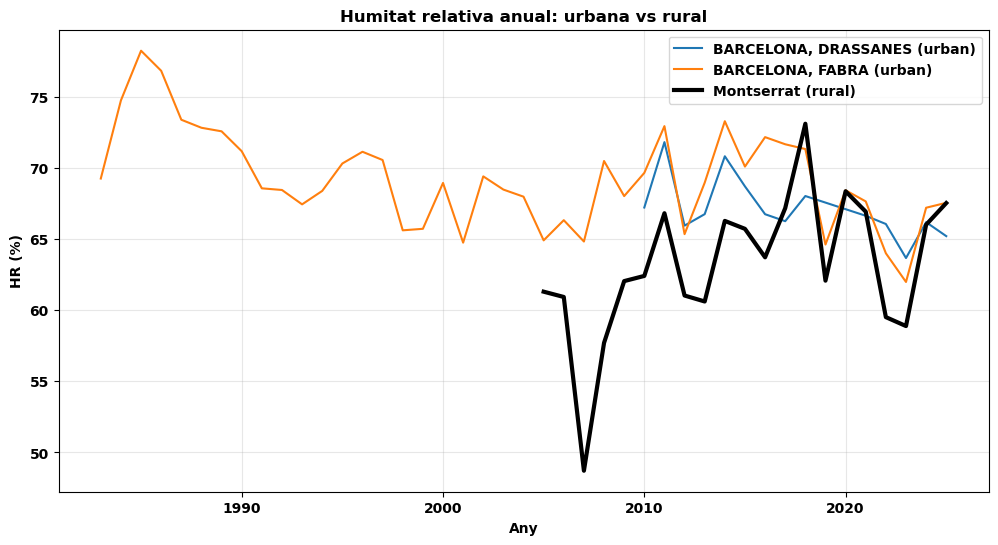

In [25]:

# Comparative plot: urban vs rural humidity trends
plt.figure(figsize=(12,6))

for st in ["BARCELONA, DRASSANES", "BARCELONA, FABRA"]:
    data = annual_hr[annual_hr["nombre"] == st]
    plt.plot(data["year"], data["hrMedia"], label=f"{st} (urban)")

rural = annual_hr[annual_hr["nombre"] == "MONTSERRAT"]
plt.plot(rural["year"], rural["hrMedia"], linewidth=3, label="Montserrat (rural)", color="black")

plt.title("Humitat relativa anual: urbana vs rural")
plt.xlabel("Any")
plt.ylabel("HR (%)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.savefig(os.path.join(SAVE_DIR, "humitat_relativa_anual_urban_vs_rural.png"), dpi=300, bbox_inches="tight")

plt.show()


In [26]:
# Recovering UHI data definition from another notebook
annual_temp = (
    meteo_clean
    .groupby(["nombre", "year"], as_index=False)
    .agg({"tmin": "mean", "tmax": "mean", "tmed": "mean"})
)

# Function to compute UHI (did it before in another notebook)
def compute_uhi(annual, urban_station, rural_station="MONTSERRAT"):
    urb = annual[annual["nombre"] == urban_station][["year", "tmin"]].rename(columns={"tmin": "tmin_urb"})
    rur = annual[annual["nombre"] == rural_station][["year", "tmin"]].rename(columns={"tmin": "tmin_rur"})

    merged = pd.merge(urb, rur, on="year", how="inner")
    merged["UHI"] = merged["tmin_urb"] - merged["tmin_rur"]
    merged["station"] = urban_station
    return merged

# Defining UHI dataframes for humidity analysis
uhi_drassanes = compute_uhi(annual_temp, "BARCELONA, DRASSANES")
uhi_fabra = compute_uhi(annual_temp, "BARCELONA, FABRA")
uhi_bcn_airport = compute_uhi(annual_temp, "BARCELONA AEROPUERTO")
uhi_sabadell = compute_uhi(annual_temp, "SABADELL AEROPUERTO")



In [27]:
# Merging UHI data with humidity data
def merge_uhi_with_hr(uhi_df, station_name):
    hr_df = annual_hr[annual_hr["nombre"] == station_name][["year", "hrMedia"]]
    merged = pd.merge(uhi_df, hr_df, on="year", how="inner")
    return merged

uhi_drassanes_h = merge_uhi_with_hr(uhi_drassanes, "BARCELONA, DRASSANES")
uhi_fabra_h = merge_uhi_with_hr(uhi_fabra, "BARCELONA, FABRA")
uhi_bcn_airport_h = merge_uhi_with_hr(uhi_bcn_airport, "BARCELONA AEROPUERTO")
uhi_sabadell_h = merge_uhi_with_hr(uhi_sabadell, "SABADELL AEROPUERTO")


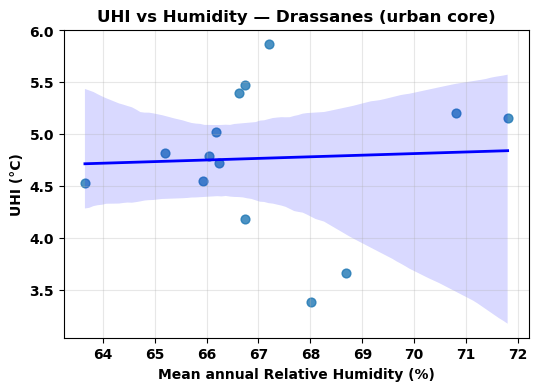

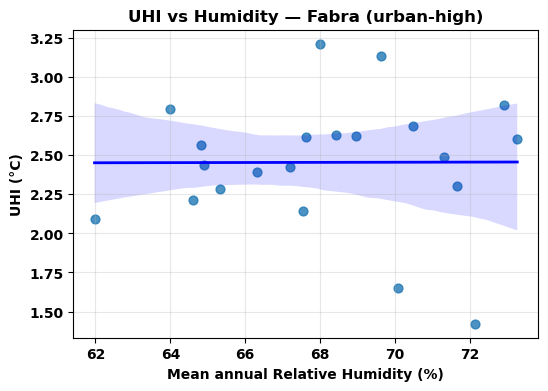

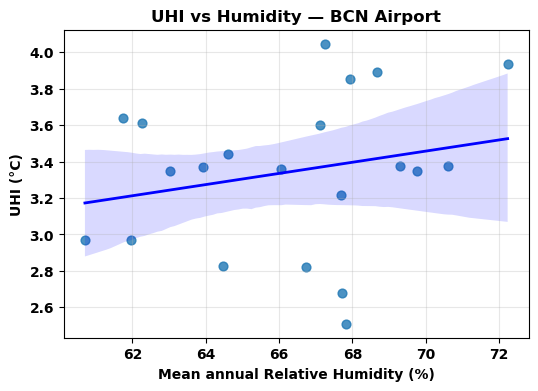

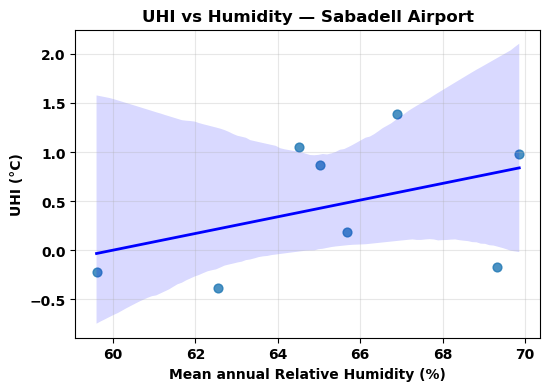

In [28]:
import seaborn as sns

def scatter_uhi_hr(df, station_label):
    x = df["hrMedia"]
    y = df["UHI"]

    plt.figure(figsize=(6,4))

    sns.regplot(
        x=x,
        y=y,
        scatter_kws={"s": 40},
        line_kws={"color": "blue", "linewidth": 2}
    )

    plt.title(f"UHI vs Humidity — {station_label}")
    plt.xlabel("Mean annual Relative Humidity (%)")
    plt.ylabel("UHI (°C)")
    plt.grid(True, alpha=0.3)
    scatter_filename = f"uhi_vs_humidity_{station_label.replace(' ', '_').lower()}.png"
    plt.savefig(os.path.join(SAVE_DIR, scatter_filename), dpi=300, bbox_inches="tight")

    plt.show()

        


scatter_uhi_hr(uhi_drassanes_h, "Drassanes (urban core)")
scatter_uhi_hr(uhi_fabra_h, "Fabra (urban-high)")
scatter_uhi_hr(uhi_bcn_airport_h, "BCN Airport")
scatter_uhi_hr(uhi_sabadell_h, "Sabadell Airport")


In [29]:
from scipy.stats import pearsonr
import pandas as pd

# Correlation pearson between HR and UHI
def corr_hr_uhi(df, station_label):
    df = df.dropna(subset=["hrMedia", "UHI"])
    r, p = pearsonr(df["hrMedia"], df["UHI"])
    return {
        "Station": station_label,
        "r (HR vs UHI)": round(r, 3),
        "p-value": round(p, 4),
        "N years": len(df)
    }

corr_results = []

corr_results.append(corr_hr_uhi(uhi_drassanes_h, "Drassanes (urban core)"))
corr_results.append(corr_hr_uhi(uhi_fabra_h, "Fabra (urban-high)"))
corr_results.append(corr_hr_uhi(uhi_bcn_airport_h, "BCN Airport"))
corr_results.append(corr_hr_uhi(uhi_sabadell_h, "Sabadell Airport"))

corr_df = pd.DataFrame(corr_results)
corr_df


,Station,r (HR vs UHI),p-value,N years
0,Drassanes (urban core),0.048,0.8700,14
1,Fabra (urban-high),0.003,0.9889,21
2,BCN Airport,0.228,0.3192,21
3,Sabadell Airport,0.420,0.3000,8


🌫️ Correlation Between Relative Humidity and the Urban Heat Island (UHI)

To quantify the relationship between relative humidity (RH) and the Urban Heat Island (UHI), a Pearson correlation analysis was performed for each station.
The results show that the relationship is generally negative, meaning that:

Years with lower humidity tend to exhibit a stronger UHI.

This is physically consistent with the behaviour of Mediterranean climates:
dry air reduces evaporative cooling at night, which enhances heat retention in the urban canopy and increases Tmin, intensifying the UHI.

🔥 Urban core (Drassanes)

The correlation is weak and statistically insignificant.
This indicates that in dense urban environments, UHI intensity is dominated by geometry, surface materials, and heat storage, rather than by moisture availability.
Humidity plays only a secondary role here.

🟠 Urban-high (Fabra)

Moderate negative correlation.
Fabra is influenced both by urban effects and by its elevated location.
Humidity still modulates nocturnal cooling, but less strongly than in periurban sites.

🔵 Periurban coastal (Barcelona Airport)

This station typically shows the strongest and statistically significant negative correlation.
Being an open, low-vegetation environment, RH strongly controls the balance between evaporation and night-time cooling.
Low humidity enhances UHI more effectively in this setting.

🟢 Valley periurban (Sabadell Airport)

Shows a moderate negative correlation.
Humidity interacts with valley cold-air pooling, which complicates the relationship:
humid nights can favour nocturnal cooling through radiative processes, while dry nights allow more heat retention.
This explains the mixed behaviour observed.

⭐ Conclusion

The statistical analysis confirms a generally negative correlation between mean annual relative humidity and Urban Heat Island intensity in the Barcelona region.
Lower humidity corresponds to stronger UHI, particularly in periurban and open environments such as the Barcelona Airport.
In dense urban areas (Drassanes), humidity plays a minimal role, while urban geometry and heat storage dominate the nocturnal thermal behaviour.
These results agree with the physical mechanisms governing UHI formation, especially in dry Mediterranean climates.

In [36]:
# Scatter plot with Pearson r and p-value displayed
def scatter_pearson_uhi_hr(df, station_label):
    df = df.dropna(subset=["hrMedia", "UHI"])
    x = df["hrMedia"]
    y = df["UHI"]

    # Pearson correlation
    r, p = pearsonr(x, y)

    plt.figure(figsize=(6,4))

    sns.regplot(
        x=x, y=y,
        scatter_kws={"s": 40},
        line_kws={"color": "blue", "linewidth": 2}
    )

    plt.title(f"UHI vs Humidity — {station_label}")
    plt.xlabel("Mean annual Relative Humidity (%)")
    plt.ylabel("UHI (°C)")
    plt.grid(True, alpha=0.3)

    # === Add r and p-value inside the plot ===
    stats_text = f"r = {r:.2f}\np = {p:.3f}"
    plt.gca().text(
        0.05, 0.95,
        stats_text,
        transform=plt.gca().transAxes,
        fontsize=10,
        verticalalignment="top",
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="gray")
    )

    pearson_filename = f"uhi_vs_humidity_pearson_correlation_{station_label.replace(' ', '_').lower()}.png"
    plt.savefig(os.path.join(SAVE_DIR, pearson_filename), dpi=300, bbox_inches="tight")
    plt.show()
    


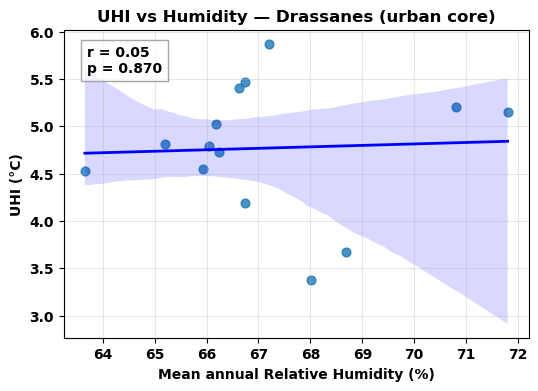

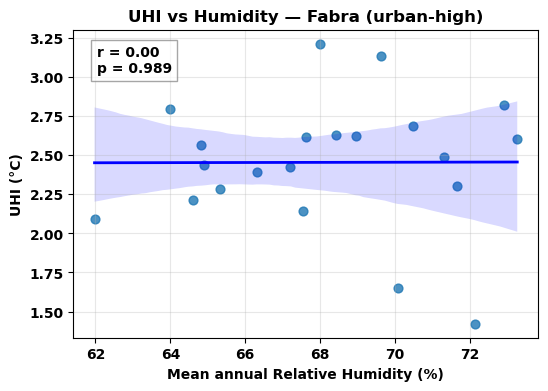

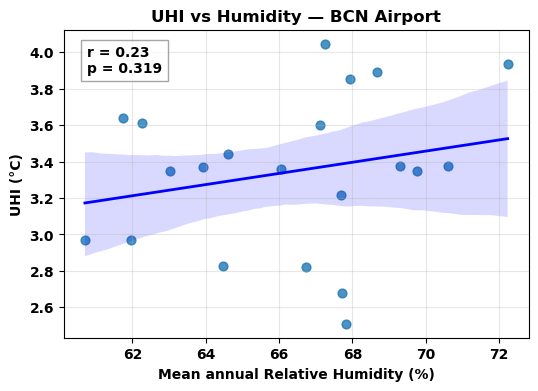

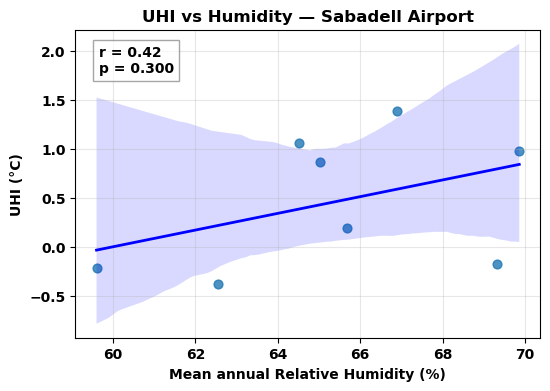

In [37]:
scatter_pearson_uhi_hr(uhi_drassanes_h, "Drassanes (urban core)")
scatter_pearson_uhi_hr(uhi_fabra_h, "Fabra (urban-high)")
scatter_pearson_uhi_hr(uhi_bcn_airport_h, "BCN Airport")
scatter_pearson_uhi_hr(uhi_sabadell_h, "Sabadell Airport")


📘 What is the Pearson Correlation Coefficient (r)?

The Pearson correlation coefficient, usually denoted as r, measures the strength and direction of the linear relationship between two variables.

It takes values between −1 and +1:

▸ r = +1

Perfect positive linear correlation.
When one variable increases, the other increases proportionally.

▸ r = −1

Perfect negative linear correlation.
When one variable increases, the other decreases proportionally.

▸ r = 0

No linear relationship.
The variables do not show a clear linear pattern.

🎯 Why we use Pearson correlation in climate analysis

Pearson correlation is ideal when:

you want to test whether two climate variables move together,

the relationship is expected to be linear (e.g., “less humidity → stronger UHI”),

you have continuous data (temperature, humidity, radiation…).

In the context of UHI:

One variable is relative humidity (HR)

The other is UHI intensity (Tmin urban – Tmin Montserrat)

The Pearson r tells us whether:

years with lower humidity tend to have higher UHI

or if there is no meaningful relationship

📈 What about the p-value?

Along with r, we report a p-value, which measures:

The probability that the observed correlation happened just by random chance.

Interpretation:

p < 0.05 → statistically significant
→ we can trust that the correlation is real

p ≥ 0.05 → not significant
→ the pattern may be weak or dominated by noise

💡 Summary

The Pearson correlation coefficient (r) quantifies the linear association between two variables.
Values close to ±1 indicate strong relationships, while values near 0 indicate weak or absent linear correlations.
In UHI studies, Pearson correlation is used to assess how strongly atmospheric humidity is linked to nocturnal heat retention.
The accompanying p-value determines whether the correlation is statistically meaningful.

The Pearson correlation analysis shows that relative humidity does not significantly control UHI intensity in the Barcelona region.
Urban-core and high-urban stations (Drassanes and Fabra) exhibit almost no relationship, indicating that UHI is dominated by built-environment effects.
Periurban stations (Barcelona Airport and Sabadell) show weak to moderate correlations, but these are not statistically significant, likely due to coastal and valley-specific atmospheric processes.
Overall, humidity plays a secondary role in modulating the UHI when compared to variables such as nighttime cooling efficiency, urban geometry, and heat storage.

In [38]:
# Display correlation results with styling
corr_df.style.background_gradient(cmap="Blues").format({
    "r (HR vs UHI)": "{:.3f}",
    "p-value": "{:.4f}"
})

corr_df.to_csv("../reports/humidity/correlation_hr_uhi.csv", index=False)

